In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.interpolate import interp1d
import pickle
from scipy.signal import medfilt

In [12]:
def conv(signal, kernel):
    signal_length = len(signal)
    kernel_length = len(kernel)
    output_length = signal_length - kernel_length + 1
    result = np.zeros(output_length)

    for i in range(output_length):
        signal_slice = signal[i:i + kernel_length]
        norm_signal_slice = signal_slice / np.linalg.norm(signal_slice)
        norm_kernel = kernel / np.linalg.norm(signal_slice)
        
        result[i] = np.dot(norm_signal_slice, norm_kernel)
        
    return result

In [13]:
def amplitude_in_band(conv_res, min_fr, max_fr):
    frequencies, _, Zxx = signal.stft(
        conv_res,
        fs=64,
        window='hann',
        nperseg=256,
        noverlap=250
    )

    freq_mask = (frequencies >= min_fr) & (frequencies <= max_fr)

    amplitude_in_band = np.mean(np.abs(Zxx[freq_mask, :]), axis=0)

    return amplitude_in_band


In [14]:
def create_mask(min_amplitude, max_amplitude, min_len_interval, amplitude_in_band, len_ppg):
    cross_above_min = np.where((amplitude_in_band[:-1] < min_amplitude) & (amplitude_in_band[1:] >= min_amplitude))[0] + 1
    cross_below_min = np.where((amplitude_in_band[:-1] >= min_amplitude) & (amplitude_in_band[1:] < min_amplitude))[0] + 1

    intervals = []
    start = None
    
    if amplitude_in_band[0] >= min_amplitude:
        start = 0
        
    for i in range(len(cross_above_min)):
        start = cross_above_min[i]
        
        end_candidates = cross_below_min[cross_below_min > start]
        if len(end_candidates) == 0:
            break
        end = end_candidates[0]
        
        intervals.append((start, end))
        
        start = None

    valid_intervals = []
    for start, end in intervals:
        if np.any(amplitude_in_band[start:end] > max_amplitude) or ((end - start) < min_len_interval):
            continue
        valid_intervals.append((start, end))

    time_mask = np.zeros_like(amplitude_in_band, dtype=bool)
    for start, end in valid_intervals:
        time_mask[start:end] = True


    # kernel = np.ones(10)
    # time_mask = binary_closing(time_mask, kernel)
    # time_mask_clean = binary_opening(time_mask, kernel)

    indices_mask = np.arange(len(time_mask))
    indices_ppg = np.linspace(0, len(time_mask) - 1, len_ppg)

    mask_func = interp1d(
        indices_mask,
        time_mask,
        kind='nearest',
        bounds_error=False,
        fill_value=False
    )

    full_mask = mask_func(indices_ppg).astype(bool)

    return full_mask


In [15]:
def drow_data(ppg, ylim, person_name, status):
    if len(ppg) > 0:
        wigth = len(ppg) // 256
        figr = plt.figure(figsize=(wigth, 6))
        plt.plot(ppg)
        plt.grid(True)  
        plt.ylim(ylim[0], ylim[1])
        plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/{person_name}_{status}.png', dpi=300, bbox_inches='tight')
        plt.close(figr)


In [16]:
def filt_data(ppg, path_to_ref_signal, min_fr, max_rf, min_amp, max_amp, min_interval_len):
    reference_wave = np.load(path_to_ref_signal)
    conv_res = conv(ppg, reference_wave)
    res_amplitude = amplitude_in_band(conv_res, min_fr, max_rf)
    mask = create_mask(min_amp, max_amp, min_interval_len, res_amplitude, len(ppg))
    filt_ppg = ppg[mask]

    return filt_ppg

In [17]:
def bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

In [18]:
def adaptive_normalization(signal, window_size=256):
    normalized = np.zeros_like(signal)

    for i in range(len(signal)):
        start = max(0, i - window_size // 2)
        end = min(len(signal), i + window_size // 2)

        local_mean = np.mean(signal[start:end])
        local_std = np.std(signal[start:end])

        normalized[i] = (signal[i] - local_mean) / local_std
    return normalized

In [19]:
def norm_data(ppg):
    pass

In [20]:
min_fr = 1
max_rf = 2
min_amp = 0.07
max_amp = 0.24
min_interval_len = 128

ppg_sr = 256

In [21]:
data = pd.read_csv('/home/ilya/Documents/stress-level-by-PPG/dataframe/shoulder.csv')
display(data.head())

ppg = data["afe_LED1ABSVAL"][0 : ppg_sr * 400]

,device_name,comment,package_number,time,eda,accel_X,accel_Y,accel_Z,afe_LED1ABSVAL,battery,temperature,package_num
0,shoulder,device,29,2025-03-22 23:46:24.656276,756,65509,65533,64542,16557002,3947,0,40
1,shoulder,device,29,2025-03-22 23:46:24.656367,750,65509,65533,64542,16544756,3933,0,40
2,shoulder,device,29,2025-03-22 23:46:24.656383,750,65509,65533,64542,16534144,3947,0,40
3,shoulder,device,29,2025-03-22 23:46:24.656563,750,65509,65533,64542,16532926,3933,0,40
4,shoulder,device,29,2025-03-22 23:46:24.656596,750,65509,65533,64542,16532351,3933,0,40


In [22]:
ppg = bandpass_filter(ppg, 1, 3, ppg_sr)
# ppg_adaptive = adaptive_normalization(ppg, 512)

drow_data(ppg, (-4000, 4000), "Ilia_bandpass", "md")
# drow_data(ppg_adaptive, (-4, 4), "Ilia_adaptive", "md")

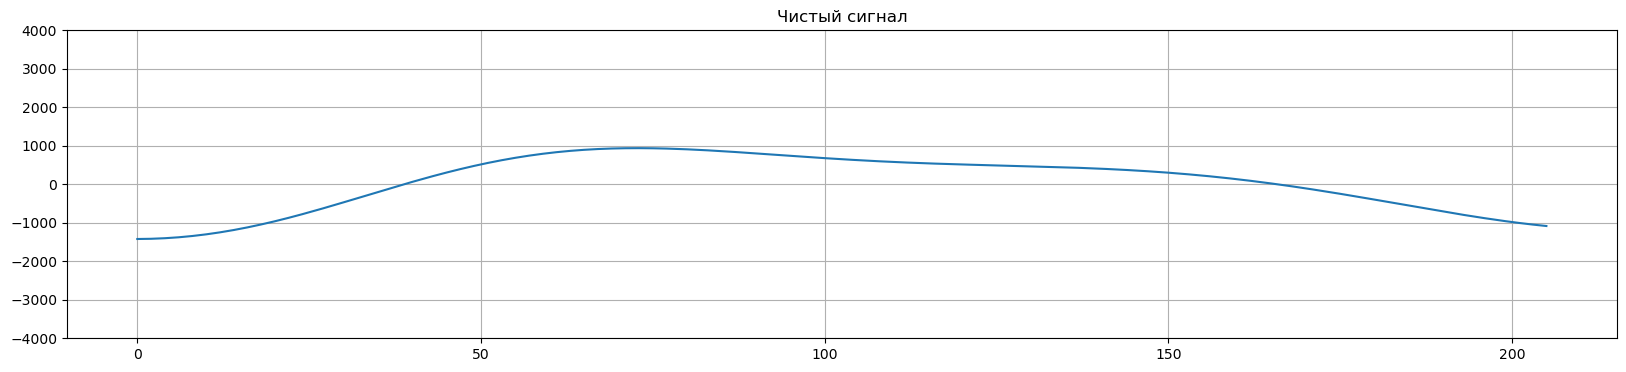

In [27]:
sec_with = 212
count_sec = 1

reference_wave = ppg[ppg_sr * sec_with + 50: ppg_sr * (count_sec + sec_with)]

plt.figure(figsize=(20, 4))
plt.plot(reference_wave)
plt.title("Чистый сигнал")
plt.ylim(-4000, 4000)
plt.grid(True)

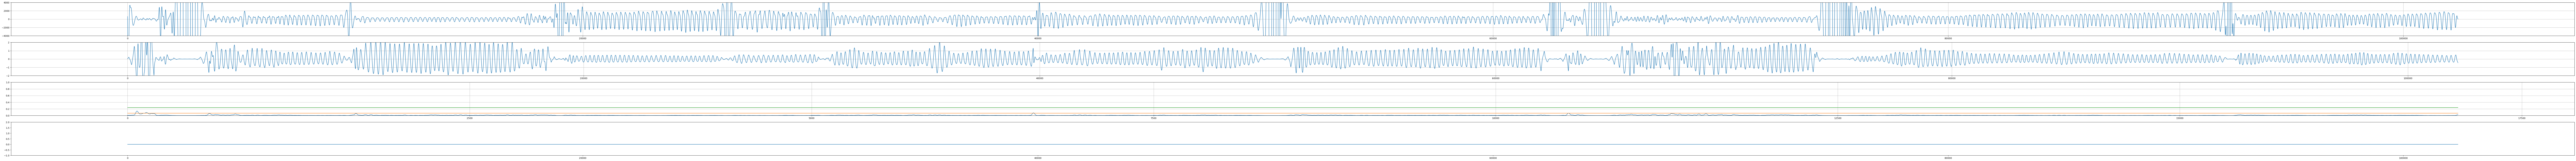

In [29]:
conv_res = conv(ppg, reference_wave)
res_amplitude = amplitude_in_band(conv_res, min_fr, max_rf)
mask = create_mask(min_amp, max_amp, min_interval_len, res_amplitude, len(ppg))
filt_ppg = ppg[mask]

plt.figure(figsize=(200, 12))

plt.subplot(4, 1, 1)
plt.plot(ppg)
plt.ylim(-4000, 4000)
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(conv_res)
plt.ylim(-2, 2)
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(res_amplitude)
plt.plot([min_amp] * len(res_amplitude))
plt.plot([max_amp] * len(res_amplitude))
plt.ylim(0, 1)
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(mask)
plt.ylim(-1, 2)

plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/ppg-conv-ampl-mask.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# filt_ppg = ppg[mask]

# plt.figure(figsize=(50, 4))
# plt.plot(filt_ppg)
# plt.grid(True)
# plt.savefig(f'./res_filt_signal.png', dpi=300, bbox_inches='tight')